# Coding a MaskGIT autoencoder in Pytorch

For any remark or suggestion on this lab, please feel free to contact me at:
*   loic dot lefolgoc at telecom-paris dot fr.


## Objective:

The goal of this TP is to __explore VQ-VAEs and MaskGIT__, a generative image transformer model operating on tokenized representations (as typically output by VQ-VAEs). We will design a MaskGIT autoencoder applied to MNIST.

## Your task:
You need to __add the missing parts in the code__ (parts between # --- START CODE HERE and # --- END CODE HERE or # FILL IN CODE or ...).<br>

You can train models for a few epochs on CPU or GPU to check that your code works. To save your time, __I actually provide models trained for longer for all parts of the lab__, which you can load once the relevant code is completed, before moving on to the next part.

__Please upload the lab by the deadline as a .ipynb or a .zip named SURNAME_FirstName.ipynb or .zip__

First of all, let's load some packages:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import pdb
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm

In [3]:
!pip install vector-quantize-pytorch

In [4]:
!pip install einops

In [5]:
from einops import rearrange, repeat

In [6]:
from vector_quantize_pytorch import VectorQuantize

# 1. Loading MNIST

First, we __load the mnist dataset__. You should be able to train for a couple of epochs on the full training dataset `mnist_trainset` even on CPU, but should you need it, we create a reduced trainset below.

Feel free to train on `mnist_trainset_reduced` instead if you prefer. To do so, replace the argument `mnist_trainset` in the `torch.utils.data.DataLoader(...)` call creating `mnist_train_loader` in the cell below by `mnist_trainset_reduced` (and same for `mnist_testset` and `mnist_testset_reduced`).

In [7]:
# MNIST Dataset
mnist_trainset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_testset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)


In [8]:
# create reduced datasets for quick experimentation

# train
max_mnist_size = 10000
mnist_trainset_reduced = torch.utils.data.random_split(mnist_trainset, [max_mnist_size, len(mnist_trainset)-max_mnist_size])[0]

# test
max_mnist_size = 1000
mnist_testset_reduced = torch.utils.data.random_split(mnist_testset, [max_mnist_size, len(mnist_testset)-max_mnist_size])[0]

In [9]:
batch_size = 64

In [10]:
# create the dataloaders
mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size, shuffle=True, drop_last=False)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [11]:
mnist_trainset.data.shape

torch.Size([60000, 28, 28])

# 2. VQ-VAE

The first part of the lab is about __training a VQ-VAE model__. We will abstract details about quantization and commitment loss by using an existing library that takes care of this for us via the `VectorQuantize` layer. We will however have to build the encoding-decoding architecture around it.





## 2.1 Building the VQ-VAE

The VQ-VAE model consists of
*   an encoder, which maps from the original image space $H_0\times W_0\times 1$ to a lower-resolution image space $h\times w\times D$
*   a `VectorQuantize` layer, which does the quantization i.e., turns the output of the encoder to $h\times w$ images of integer tokens. It is also able to compute the commitment_loss, which is added to the reconstruction loss when training. Finally, it also returns quantized embeddings $h\times w\times D$ (a quantized version of the encoder output, which serves as the decoder input).
*   a decoder, which goes back from quantized embeddings $h\times w\times D$ to an image $H_0\times W_0\times 1$

The encoder/decoder consist of down/upsampling layers (conv or transpose conv with stride 2) and a residual stack to further process the feature maps.

In [12]:
class ResidualStack(nn.Module):
    '''
    The ResidualStack is already coded for you.
    '''
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        '''
        :args:
          x -> FloatTensor(), shape (C, H, W): the input
        :return:
          FloatTensor(), shape (C, H, W): the output of the same shape.
        '''
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)

Let's code the `Encoder`. It consists of `self.conv`, a `nn.Sequential()` object with `num_downsampling_layers` downsampling layers, which are convolutions with
*   stride of 2
*   kernel size: 4x4
*   padding: 1

and a final conv (k:3x3 padding:1, stride:1) which outputs an image with `num_hidden` channels; this is followed by a `ResidualStack` with `num_residual_layers` and internally `num_residual_hiddens` channels.



In [13]:
class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()

        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            # Add the Conv2d layer
            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(in_channels, out_channels, (4,4), 2, 1),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        # Add the final Conv2d layer
        conv.add_module(
            "final_conv",
            nn.Conv2d(out_channels, num_hiddens, (3,3), 1, 1),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(num_hiddens, num_residual_layers, num_residual_hiddens)

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)

In [14]:
# Test the Encoder class by running this cell

# The input shape is (5, 1, 28, 28), the output shape should be (5, 10, 7, 7).

temp = torch.randn(5, 1, 28, 28)
temp = Encoder(in_channels = 1,
               num_hiddens = 10,
               num_downsampling_layers = 2,
               num_residual_layers = 2,
               num_residual_hiddens = 5
               )(temp)
temp.shape

torch.Size([5, 10, 7, 7])

Next we code the `Decoder`. It starts with a `self.conv` layer, a `Conv2d` layer which projects from (embedding_dim, h, w) to (num_hidden, h, w). Then a `ResidualStack` follows to mirror the encoder. Then upsampling `ConvTranspose2d` layers listed in a `nn.Sequential()` object, with:
*   kernel size: 4x4
*   stride: 2
*   padding: 1



In [15]:
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        x_channels
    ):
        super().__init__()

        self.conv = nn.Conv2d(embedding_dim, num_hiddens, (3,3), 1, 1)

        self.residual_stack = ResidualStack(num_hiddens, num_residual_layers, num_residual_hiddens)

        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            else:
                (in_channels, out_channels) = (num_hiddens // 2, x_channels)

            # Add the ConvTranspose2d
            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(in_channels, out_channels, (4,4), 2, 1)
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return x_recon

In [16]:
# Test the Decoder class by running this cell

# The input shape is (5, 5, 7, 7), the output shape should be (5, 1, 28, 28).

temp = torch.randn(5, 5, 7, 7)
temp = Decoder(embedding_dim = 5,
               num_hiddens = 10,
               num_upsampling_layers = 2,
               num_residual_layers = 2,
               num_residual_hiddens = 5,
               x_channels = 1
               )(temp)
temp.shape

torch.Size([5, 1, 28, 28])

The `VQVAE` class wraps it all together: `Encoder`, `VectorQuantize` layer, `Decoder`.
* The `forward` will be called at training time. It attempts to reconstruct its input (auto-encoding). It relies on a call to the `quantize` routine.
* At inference time, we will call the `encode` and `decode` routines instead, which respectively let us obtain the (integer) image tokens, and reconstruct an image from input tokens.<br>

Fill the missing parts (more details provided in the code).

The main calls to interact with the `VectorQuantize` layer (say, an instance `vq`) are:
* `z_quantized, encoding_indices, commitment_loss = vq(z)`, where `z` are D-dimensional embeddings output by an encoder, that are compared to `K` D-dimensional codes in a codebook
* `z_quantized = vq.get_output_from_indices(encoding_indices)` in case you start from a grid of tokens and want to compute the corresponding quantized embeddings; the output format for this routine and this routine only is `(b, h, w, d)` instead of the `(b, d, h, w)` required by most layers (like convolutional layers), so that a rearrange will be needed afterwards.

In [17]:
class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,              # number of input channels
        num_hiddens,              # cf. Encoder and Decoder
        num_downsampling_layers,  # if set to 2, downsample factor is 4
        num_residual_layers,      # cf. Encoder and Decoder
        num_residual_hiddens,     # cf. ResidualStack
        embedding_dim,            # the length of a vector in the codebook (D)
        codebook_size,            # the size of the codebook (K)
        decay = 0.8,              # technical parameter (for EMA updates of the codebook), lower means the dictionary will change faster
        commitment_weight = 1.,   # the weight of the commitment_loss compared to the reconstruction loss
    ):
        super().__init__()

        # class Encoder()
        self.encoder = Encoder(in_channels, num_hiddens, num_downsampling_layers, num_residual_layers, num_residual_hiddens)

        # An additional Conv2d called right after the encoder to project from
        # num_hidden channels to embedding_dim channels (so that embeddings
        # can be compared to the codes in the codebook).
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )

        # The quantization layer
        self.vq = VectorQuantize(
            dim = embedding_dim,
            codebook_size = codebook_size,
            decay = decay,
            commitment_weight = commitment_weight,
            accept_image_fmap = True  # overrides the default, which is to deal with 1D signals
        )

        # class Decoder()
        self.decoder = Decoder(embedding_dim, num_hiddens, num_downsampling_layers, num_residual_layers, num_residual_hiddens, 1)

    def quantize(self, x):
        '''
        :args
            x -> FloatTensor() - (b, c, H0, W0): the batch of input images
        :return
            z_quantized -> FloatTensor() - (b, D, h, w): the quantized embeddings
            commitment_loss -> FloatTensor() - (b,): the commitment loss value for all samples in the minibatch. cf. VQ-VAE paper
            encoding_indices -> LongTensor() - (b, h, w): the grid of (integer) tokens
        '''

        # Pass through encoder, then through pre_vq_conv
        z = self.pre_vq_conv(self.encoder(x))

        # Pass through the vector quantization layer
        z_quantized, encoding_indices, commitment_loss = self.vq(z)    # outputs are (b, h, w, d), (b, h, w), (b)

        return (z_quantized, commitment_loss, encoding_indices)

    def forward(self, x):
        # Encode and quantize
        (z_quantized, commitment_loss, _) = self.quantize(x)

        # Reconstruct by passing through the decoder z_quantized
        x_rec = self.decoder(z_quantized)

        return {
            "commitment_loss": commitment_loss,
            "x_rec": x_rec,
        }

    def encode(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        z_quantized, encoding_indices, _ = self.vq(z)

        return encoding_indices, z_quantized, z

    def decode(self, code_indices):
        # Generate z_quantized from code_indices (see hint in the text above this cell)
        z_quantized = self.vq.get_output_from_indices(code_indices)
        z_quantized = rearrange(z_quantized, 'b h w d -> b d h w')

        return self.decoder(z_quantized)

In [18]:
# Test the VQVAE class by running this cell

temp = torch.randn(2, 1, 28, 28)
vq_temp = VQVAE(
    in_channels = 1,
    num_hiddens = 10,
    num_downsampling_layers = 2,
    num_residual_layers = 2,
    num_residual_hiddens = 5,
    embedding_dim = 5,
    codebook_size = 100,
    decay = 0.9,
    commitment_weight = 1.
)

temp_o = vq_temp(temp)
print('Reconstructed shape: {}'.format(temp_o['x_rec'].shape)) # should be (2, 1, 28, 28)

temp_tokens, temp_z_quantized, _ = vq_temp.encode(temp)
print('Tokens shape: {}'.format(temp_tokens.shape)) # should be (2, 7, 7)
print('Quantized embeddings shape: {}'.format(temp_z_quantized.shape)) # should be (2, 5, 7, 7)

temp_o = vq_temp.decode(temp_tokens)
print('Reconstructed shape: {}'.format(temp_o.shape)) # should be (2, 1, 28, 28)

Reconstructed shape: torch.Size([2, 1, 28, 28])
Tokens shape: torch.Size([2, 7, 7])
Quantized embeddings shape: torch.Size([2, 5, 7, 7])
Reconstructed shape: torch.Size([2, 1, 28, 28])


## 2.2. Training the VQ-VAE

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The training proceeds as usual. We instantiate a model, move it to the correct device, create an optimizer and write the training loop.

In [20]:
# Parameters
in_channels = 1
num_hiddens = 64
num_downsampling_layers = 2
num_residual_layers = 2
num_residual_hiddens = 32
embedding_dim = 32
codebook_size = 64

learning_rate = 1e-4
n_epoch = 10 # if running on GPU you can use more epochs

In [21]:
# Model
vqvae_model = VQVAE(
    in_channels,
    num_hiddens,
    num_downsampling_layers,
    num_residual_layers,
    num_residual_hiddens,
    embedding_dim,
    codebook_size,
    )

In [22]:
vqvae_model = vqvae_model.to(device)

In [23]:
# Use the AdamW optimizer, set the correct learning rate and weight_decay to 1e-4
optimizer = optim.AdamW(vqvae_model.parameters(), lr=learning_rate, weight_decay=1e-4)

Let us write the training loop. We should use a reconstruction loss adapted to binary masks. Note that the decoder of VQVAE ends with a `Conv2d` rather than a `sigmoid`, which means that it outputs logits rather than probabilities. __Which reconstruction loss is suitable?__
* `F.mse_loss`
* `F.cross_entropy`
* `F.binary_cross_entropy`
* `F.binary_cross_entropy_with_logits`

You can use `reduction="mean"`.

In [24]:
vqvae_model.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm(mnist_train_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device, GPU or CPU
      data = data.to(device)

      # Pass the input data through the model
      predict = vqvae_model(data)
      x_hat = predict['x_rec']

      # Compute the VQ-VAE loss
      reconstruction_loss = F.binary_cross_entropy_with_logits(x_hat, data, reduction='mean')
      commitment_loss = predict['commitment_loss'].mean()
      loss = reconstruction_loss + commitment_loss

      # Backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Aggregate the training loss for display at the end of the epoch
      train_loss += loss.item()

      # tqdm bar displays the loss
      tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(mnist_train_loader)))

Epoch 0: 100%|██████████| 938/938 [00:27<00:00, 34.53batch/s, loss=0.0834]


Epoch 0: Train Loss: 0.1693


Epoch 1: 100%|██████████| 938/938 [00:19<00:00, 48.49batch/s, loss=0.0757]


Epoch 1: Train Loss: 0.0812


Epoch 2: 100%|██████████| 938/938 [00:18<00:00, 49.47batch/s, loss=0.0728]


Epoch 2: Train Loss: 0.0767


Epoch 3: 100%|██████████| 938/938 [00:19<00:00, 48.58batch/s, loss=0.0697]


Epoch 3: Train Loss: 0.0748


Epoch 4: 100%|██████████| 938/938 [00:19<00:00, 49.11batch/s, loss=0.0705]


Epoch 4: Train Loss: 0.0737


Epoch 5: 100%|██████████| 938/938 [00:20<00:00, 46.38batch/s, loss=0.0787]


Epoch 5: Train Loss: 0.0729


Epoch 6: 100%|██████████| 938/938 [00:19<00:00, 48.98batch/s, loss=0.0677]


Epoch 6: Train Loss: 0.0724


Epoch 7: 100%|██████████| 938/938 [00:19<00:00, 49.00batch/s, loss=0.0778]


Epoch 7: Train Loss: 0.0721


Epoch 8: 100%|██████████| 938/938 [00:19<00:00, 48.27batch/s, loss=0.066]


Epoch 8: Train Loss: 0.0718


Epoch 9: 100%|██████████| 938/938 [00:18<00:00, 49.41batch/s, loss=0.0783]

Epoch 9: Train Loss: 0.0717


Once you think the training goes in the right direction, hence your model is correct, you can actually __load an already trained VQVAE__ if you prefer. If your code is correct and if you kept the same model parameters, it should load without failure. Note that __if you want to use the already trained AE-MaskGIT model in the second part of the lab__ below, you __have to__ use this VQVAE that I provide you with.

In [25]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1E5uK7xccsiOoaUpClNcd5vAdZAfmXtCd' -O weights_vqvae.pth

will be placed in the single file you specified.

--2025-03-04 17:21:11--  https://drive.google.com/uc?export=download&id=1E5uK7xccsiOoaUpClNcd5vAdZAfmXtCd
Resolving drive.google.com (drive.google.com)... 74.125.135.113, 74.125.135.138, 74.125.135.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.135.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1E5uK7xccsiOoaUpClNcd5vAdZAfmXtCd&export=download [following]
--2025-03-04 17:21:11--  https://drive.usercontent.google.com/download?id=1E5uK7xccsiOoaUpClNcd5vAdZAfmXtCd&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.135.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.135.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 855686 (836K) [application/octet-stream]
Saving to: ‘weights_vqvae.pth’

weights_vqva

In [26]:
weights_dict = torch.load('weights_vqvae.pth')

<ipython-input-26-2b4f9cbf993e>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_vqvae.pth')


In [27]:
vqvae_model = VQVAE(in_channels = in_channels,
                    num_hiddens = num_hiddens,
                    num_downsampling_layers = num_downsampling_layers,
                    num_residual_layers = num_residual_layers,
                    num_residual_hiddens = num_residual_hiddens,
                    embedding_dim = embedding_dim,
                    codebook_size = codebook_size,
                    decay = 0.95)

In [28]:
vqvae_model.load_state_dict(weights_dict)

<All keys matched successfully>

In [29]:
vqvae_model = vqvae_model.to(device)

Done, let's move to testing the model!

## 2.3. Testing the VQ-VAE

We define functions for qualitative testing of the autoencoder model. We will reuse them throughout the lab.

In [30]:
def display_images(imgs):
  '''
  Display a batch of images (typically synthetic/generated images)
  '''
  r = 1
  c = imgs.shape[0]
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    # black and white images
    axs[j].imshow(imgs[j, 0,:,:].detach().cpu().numpy(), cmap='gray')
    axs[j].axis('off')
  plt.show()

def display_ae_images(ae_model, test_imgs, device):
  '''
  Display a batch of input images along with their reconstructions by a given model
    First row: input images
    Second row: reconstructed images
  '''

  ae_model.eval()

  # choose random images
  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]

  # get reconstructions
  # Don't forget to pass the output of vq_vae through a sigmoid to get images!
  output_imgs = torch.sigmoid(ae_model(test_imgs.to(device))['x_rec'])
  output_imgs = output_imgs.detach().cpu().numpy()

  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

Let's see how well the autoencoder reconstructs images from the training set:

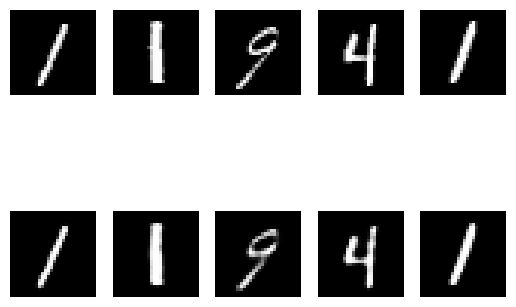

In [31]:
# reconstructing training images
train_imgs = next(iter(mnist_train_loader))[0]
display_ae_images(vqvae_model, train_imgs, device)

What about images from the test set?

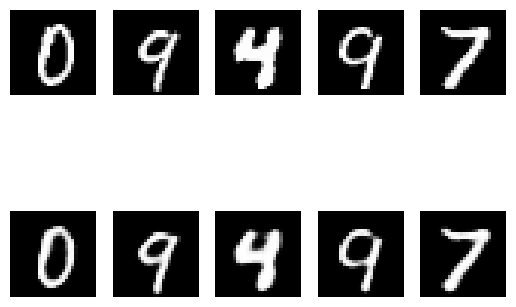

In [32]:
# reconstructing test images
test_imgs = next(iter(mnist_test_loader))[0]
display_ae_images(vqvae_model, test_imgs, device)

There is no overfitting at work here apparently. We can quantify this by computing the reconstruction loss over the test dataset (below) and compare it to the reconstruction loss over the training dataset at the end of training (check the training cell above).<br>

Note that the training loss included a commitment term, which you do not need to include here as we want to assess the reconstruction performance. Anywhere around 0.07 or better is quite good for our simple VQ-VAE!

In [33]:
vqvae_model.eval()
test_loss=0.0

n = 0
with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    # Put the data on the correct device:
    data = data.to(device)

    # Pass the data through the model
    predict = vqvae_model(data)
    x_hat = predict['x_rec']

    # Compute the AE loss
    loss = F.binary_cross_entropy_with_logits(x_hat, data, reduction = 'mean')

    # Compute the loss
    test_loss += loss.item()

    # tqdm bar displays the loss
    tepoch.set_postfix(loss=loss.item())

print('Test Loss: {:.4f}'.format(test_loss/len(mnist_test_loader)))

100%|██████████| 157/157 [00:02<00:00, 69.68batch/s, loss=0.0657]

Test Loss: 0.0713


## 2.4. Generating images from the VQ-VAE the naive way!

(or rather, failing at doing so!)<br>

How do we use our VQ-VAE as a generative model? Unfortunately it does not come with a prior! (this is why, in the second part of the lab, we will build a prior on top of the tokenized representation) <br>

We might have the naive idea that sampling uniformly at random the image tokens is good enough as a prior, and can be decoded into good-looking digits. Let's try it!

In [34]:
def generate_images_naive(vq_vae, n_images=5):
    output_tokens = torch.randint(high=2, size=(n_images, 7, 7))
    x_hat = vqvae_model.decode(output_tokens)
    return torch.sigmoid(x_hat)

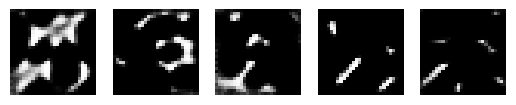

In [35]:
imgs_generated = generate_images_naive(vqvae_model, n_images=5)
display_images(imgs_generated)

This does not look too good :/ And indeed you will not make it work. We can scrap this idea and move to the second part of this lab.

# 3. Tokenized MNIST dataset/dataloader

The MaskGIT-like model that we will build \& train next processes tokenized representations. To avoid repeatedly recomputing these tokenized images from the original images on the fly in the training loop, let us build a dataset and dataloader for tokenized MNIST images, that directly stores once and for all and returns the tokenized representations. We will use this data loader in the MaskGIT training loop!

In [36]:
class tMNIST(object):
    def __init__(self, vq_vae, mnist_loader, device):
        vq_vae = vq_vae.to(device)
        self.data = self.process(vq_vae, mnist_loader, device)

    def __getitem__(self, i):
        return self.data[i]

    def process(self, vq_vae, mnist_loader, device):
        vq_vae.eval()
        codes = []

        with tqdm(mnist_loader, unit="batch") as tepoch:
            for data, labels in tepoch:
                # Put the data on the correct device:
                data = data.to(device)

                # Pass the data through the model
                encoding_indices, _, _ = vq_vae.encode(data)
                codes.append(encoding_indices.detach().clone().cpu().numpy())

        return np.concatenate(codes, axis=0)

    def __len__(self):
        return np.shape(self.data)[0]

In [37]:
# creating the tokenized MNIST datasets
tmnist_trainset = tMNIST(vqvae_model, mnist_train_loader, device)
tmnist_testset = tMNIST(vqvae_model, mnist_test_loader, device)

100%|██████████| 157/157 [00:01<00:00, 95.03batch/s]


In [38]:
# create reduced size datasets if you want
max_tmnist_size = 10000
tmnist_trainset_reduced = torch.utils.data.random_split(tmnist_trainset, [max_tmnist_size, len(tmnist_trainset)-max_tmnist_size])[0]

max_tmnist_size = 1000
tmnist_testset_reduced = torch.utils.data.random_split(tmnist_testset, [max_tmnist_size, len(tmnist_testset)-max_tmnist_size])[0]

In [39]:
batch_size = 256

In [40]:
# create tokenized MNIST dataloaders
tmnist_train_loader = torch.utils.data.DataLoader(tmnist_trainset, batch_size=batch_size, shuffle=True, drop_last=False)
tmnist_test_loader = torch.utils.data.DataLoader(tmnist_testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [41]:
tmnist_trainset.data.shape

(60000, 7, 7)

# 4. AE-MaskGIT

We are going to build our prior on top of the tokenized representations, as a modified __MaskGIT__ model. MaskGIT stands for 'Masked Generative Image Transformer' and only has generative capabilities. Our pretext task for this lab is autoencoding (we want to build a fancy VAE!), hence we will modify the MaskGIT model in a very naive way to give it autoencoding capabilities on top of its generative capabilities (more about that below).

__How is a MaskGIT trained?__ A number of tokens from the input token grids are randomly masked (replaced by a [msk] token), and the transformer model is trained to predict all tokens from what it can see. Various amounts of masking are used during training, from masking everything to masking only a small portion. In our case, there are up to 7x7=49 tokens per MNIST sample that can be masked or not.

__How does MaskGIT generate images?__ We generate an image with valid tokens by iteratively predicting them from an image with some tokens set to the [msk] token, across multiple timesteps. We start from all tokens set to [msk] at timestep 0. Various schemes can be used, we can adjust : the amounts of tokens predicted at each time step, various strategies for which tokens to predict (highest confidence, or random choice, or ...), various strategies for which token to set it to (the most likely, or randomized according to the predicted probabilities, or...), etc.

__How will we give MaskGIT autoencoding capabilities?__ We will add a number of 'code tokens' with values [cde] depending on the MNIST sample. These code tokens will be concatenated to the image tokens and be encouraged to incorporate as much information about the sample as possible to make the reconstruction more accurate, during training. In addition, we will add a `code_encoder` and a `code_decoder` (simple MLPs) to map these code tokens to and from the final vector latent representation of the sample (say, a vector with dimension 10).

With this model, encoding the tokenized images will use a `CodeTransformer` to predict the code tokens, then the `code_encoder` to obtain the latent vector. Decoding the tokenized image representation of a sample from its latent vector will first involve the `code_decoder` to obtain the code token values, then a `MaskTransformer` which performs conditional generation of the image tokens, conditioned on the code tokens.

__How do we generate new images with this modified AE-MaskGIT?__ We generate a latent vector from the prior N(0,Id), and we decode (do conditional generation of) the image tokens based on this latent vector as above.

## 4.1 Building AE-MaskGIT

The first classes, `PreNorm`, `FeedForward`, `Attention` and `TransformerEncoder`, are building blocks for `CodeTransformer` and `MaskTransformer`. I give them to you already completed because you have done enough of this in the past sessions! Take a look at `Attention`, which this time uses the optimized implementation as mentioned in the course.

In [42]:
class PreNorm(nn.Module):

    def __init__(self, dim, fn):
        """ PreNorm module to apply layer normalization before a given function
            :param:
                dim  -> int: Dimension of the input
                fn   -> nn.Module: The function to apply after layer normalization
            """
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        """ Forward pass through the PreNorm module
            :param:
                x        -> torch.Tensor: Input tensor
                **kwargs -> _ : Additional keyword arguments for the function
            :return
                torch.Tensor: Output of the function applied after layer normalization
        """
        return self.fn(self.norm(x), **kwargs)

In [43]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        """ Initialize the Multi-Layer Perceptron (MLP).
            :param:
                dim        -> int : Dimension of the input
                dim        -> int : Dimension of the hidden layer
                dim        -> float : Dropout rate
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim, bias=True),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim, bias=True),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        """ Forward pass through the MLP module.
            :param:
                x -> torch.Tensor: Input tensor
            :return
                torch.Tensor: Output of the function applied after layer
        """
        return self.net(x)

In [44]:
class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.):
        """ Initialize the Attention module.
            :param:
                embed_dim     -> int : Dimension of the embedding
                num_heads     -> int : Number of heads
                dropout       -> float : Dropout rate
        """
        super(Attention, self).__init__()
        self.dim = embed_dim
        self.mha = nn.MultiheadAttention(embed_dim, num_heads=num_heads, dropout=dropout, batch_first=True, bias=True)

    def forward(self, x):
        """ Forward pass through the Attention module.
            :param:
                x -> torch.Tensor: Input tensor
            :return
                attention_value  -> torch.Tensor: Output the value of the attention
                attention_weight -> torch.Tensor: Output the weight of the attention
        """
        attention_value, attention_weight = self.mha(x, x, x)
        return attention_value, attention_weight

In [45]:
class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, mlp_dropout=0., attn_dropout=0.):
        """ Initialize the Attention module.
            :param:
                dim       -> int : number of hidden dimension of attention
                depth     -> int : number of layer for the transformer
                heads     -> int : Number of heads
                mlp_dim   -> int : number of hidden dimension for mlp
                dropout   -> float : Dropout rate
        """
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dropout=attn_dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout=mlp_dropout))
            ]))

    def forward(self, x):
        """ Forward pass through the Attention module.
            :param:
                x -> torch.Tensor: Input tensor
            :return
                x -> torch.Tensor: Output of the Transformer
                l_attn -> list(torch.Tensor): list of the attention
        """
        l_attn = []
        for attn, ff in self.layers:
            attention_value, attention_weight = attn(x)
            x = attention_value + x
            x = ff(x) + x
            l_attn.append(attention_weight)
        return x, l_attn

The `MaskTransformer` class is one of the key ingredients of MaskGIT, yet is quite succinct. It is responsible for predicting image tokens given the image tokens themselves (some of them masked), and the code tokens. The masking is done outside of this class, in `AEMaskGIT`.

In [46]:
class MaskTransformer(nn.Module):
    def __init__(self, n_patches, n_code_tokens=1, embedding_dim=128, codebook_size=65, depth=3, heads=4, mlp_dim=256, mlp_dropout=0.1, attn_dropout=0.):
        """ Initialize the Transformer model.
            :param:
                n_patches      -> int:     Number of input/output visual patch tokens
                n_code_tokens  -> int:     Number of additional code tokens (default: 1)
                embedding_dim  -> int:     Hidden dimension for the transformer (default: 128)
                codebook_size  -> int:     Size of the codebook + 1 mask token (default: 65)
                depth          -> int:     Depth of the transformer (default: 3)
                heads          -> int:     Number of attention heads (default: 4)
                mlp_dim        -> int:     MLP dimension (default: 256)
                dropout        -> float:   Dropout rate (default: 0.1/0.)
        """

        super().__init__()
        self.n_code_tokens = n_code_tokens
        self.n_patches = n_patches
        self.codebook_size = codebook_size

        # We need to map the token to token embeddings. Create a nn.Embedding object,
        # with size the size of the codebook and the correct embedding dimension
        self.tok_emb = nn.Embedding(codebook_size, embedding_dim)

        # These positional embeddings are added to the embeddings (image+code)
        # before passing them through the transformer
        self.pos_emb = nn.init.trunc_normal_(nn.Parameter(torch.zeros(1, self.n_patches+self.n_code_tokens, embedding_dim)), 0., 0.02)

        # Class TransformerEncoder(), with all params correctly set
        self.transformer = TransformerEncoder(embedding_dim, depth, heads, mlp_dim, mlp_dropout, attn_dropout)

        # Last layer after the Transformer block, to predict token logits
        # For implementation convenience, we actually predict a logit for the
        # [msk] token value, that we discard later on.
        self.to_logits = nn.Linear(embedding_dim, self.codebook_size, bias=True)

    def forward(self, img_token, code_token, return_attn=False):
        """ Forward.
            :param:
                img_token      -> torch.LongTensor: bsize x 7 x 7, the encoded image tokens
                code_token     -> torch.FloatTensor: bsize x n_code_tokens x hidden_dim, the code tokens
                return_attn    -> Bool: return the attn for visualization
            :return:
                logit:         -> torch.FloatTensor: bsize x 7 x 7 x 65, the predicted logit
                attn:          -> list(torch.FloatTensor): list of attention for visualization
        """
        b, w, h = img_token.size()

        # Compute token embeddings from integer tokens, and rearrange from (b, w, h, d)
        # to (b, w*h, d)
        img_tok_embeddings = rearrange(self.tok_emb(img_token), 'b w h d -> b (w h) d')

        # Concatenate code tokens at the end of the image token embeddings
        tok_embeddings = torch.cat([img_tok_embeddings, code_token], -2)

        # Add position embeddings
        x = tok_embeddings + self.pos_emb

        # Pass the embeddings through the transformer
        x, attn = self.transformer(x)

        # Extract the transformed image token embeddings, and compute output logits
        # for these tokens
        logit = self.to_logits(x[:, :self.n_patches])

        # Rearrange the logits from (b, w*h, d) to (b, w, h, d)
        logit = rearrange(logit, 'b (w h) d -> b w h d', w=w, h=h)

        if return_attn:  # return list of attention
            return logit, attn

        return logit

The next class is `CodeTransformer`. It is responsible for predicting a fixed number of code tokens from the input image tokens, for encoding purposes. __These code tokens are incorporated in the same manner as the [cls] token in ViT classification models__ i.e., they are concatenated at the end of the image token sequence and processed jointly by the transformer blocks. The code tokens are initialized via a learnable embedding (just like class tokens).

In [47]:
class CodeTransformer(nn.Module):
    def __init__(self, n_patches, n_code_tokens=1, code_dim=128, embedding_dim=128, codebook_size=64, depth=3, heads=4, mlp_dim=256, mlp_dropout=0.1, attn_dropout=0.):
        """ Initialize the Transformer model.
            :param:
                n_patches      -> int:     Number of input/output visual patch tokens
                n_code_tokens  -> int:     Number of additional code tokens (default: 1)
                code_dim       -> int:     Dimension of the output codes (default: 128)
                embedding_dim  -> int:     Dimension of the hidden embeddings (default: 128)
                codebook_size  -> int:     Size of the codebook (default: 64)
                depth          -> int:     Depth of the transformer (default: 3)
                heads          -> int:     Number of attention heads (default: 4)
                mlp_dim        -> int:     MLP dimension (default: 256)
                dropout        -> float:   Dropout rate (default: 0.1/0.)
        """

        super().__init__()
        self.n_code_tokens = n_code_tokens
        self.code_dim = code_dim
        self.n_patches = n_patches
        self.codebook_size = codebook_size

        # The token embeddings. Each embedding is embedding_dim dimensional.
        # There is one embedding per token in the codebook, plus one embedding per
        # additional code token
        self.tok_emb = nn.Embedding(codebook_size + n_code_tokens, embedding_dim)


        # Positional embeddings to add to the image and code token embeddings.
        self.pos_emb = nn.init.trunc_normal_(nn.Parameter(torch.zeros(1, self.n_patches+self.n_code_tokens, embedding_dim)), 0., 0.02)

        # Class TransformerEncoder(), with all params correctly set
        self.transformer = TransformerEncoder(dim=embedding_dim, depth=depth, heads=heads, mlp_dim=mlp_dim, mlp_dropout=mlp_dropout, attn_dropout=attn_dropout)

        # Last layer after the Transformer block
        # to cast the code tokens to the correct output dimension (code_dim)
        self.linear_head = nn.Linear(embedding_dim, self.code_dim, bias=True)

    def forward(self, img_token, return_attn=False):
        """ Forward.
            :param:
                img_token      -> torch.LongTensor: bsize x 7 x 7, the encoded image tokens
                return_attn    -> Bool: return the attn for visualization
            :return:
                codes:         -> torch.FloatTensor: bsize x n_code_tokens x code_dim, the predicted codes for the samples
                attn:          -> list(torch.FloatTensor): list of attention for visualization
        """
        b, w, h = img_token.size()

        # Indices of the additional code tokens in the codebook
        code_token = torch.arange(self.n_code_tokens, device=img_token.device) + self.codebook_size

        # Repeat across minibatch dimension
        code_token = repeat(code_token, 'n -> b n', b=b)

        # Concatenate code tokens to the image tokens (after the image tokens)
        input = torch.cat([rearrange(img_token, 'b w h -> b (w h)'), code_token], -1)

        # Convert from integer tokens to token embeddings
        tok_embeddings = self.tok_emb(input)

        # Add position embedding
        x = tok_embeddings + self.pos_emb

        # Transformer forward pass
        x, attn = self.transformer(x)

        # Compute the final output (discard image tokens, only pass the code tokens through the linear head)
        codes = self.linear_head(x[:, -self.n_code_tokens:])

        # Return
        if return_attn:  # return list of attention
            return codes, attn

        return codes

The last class is the main wrapper class, `AEMaskGIT`, which implements most of the high-level routines for training, auto-encoding, encoding, decoding, and tokenized image generation. Fill the missing parts.

In [48]:
class AEMaskGIT(nn.Module):
    def __init__(self, mask_transformer, code_transformer, latent_dim=10, n_code_tokens=1, code_dim=128, codebook_size=64, mlp_dim=128, decoding_steps=8):
        super().__init__()

        # Parameters
        self.latent_dim = latent_dim
        self.n_code_tokens = n_code_tokens
        self.code_dim = code_dim
        self.codebook_size = codebook_size
        self.steps = decoding_steps

        # MaskTransformer and CodeTransformer instances
        self.mask_transformer = mask_transformer # useful to predict the masked tokens
        self.code_transformer = code_transformer # useful to "encode" a tokenized image into a set of code tokens
            # The code tokens will further be processed by self.code_encoder to
            # transform them into a latent vector (or rather a Gaussian distribution of latent vectors, like in VAEs)

        # To transform code tokens into variational posterior distributions of latent vectors
        # q(z|x)
        self.code_encoder = nn.Sequential(
            nn.Linear(code_dim*n_code_tokens, mlp_dim),
            nn.Tanh(),
            nn.Linear(mlp_dim, latent_dim*2)
        )

        # To go from a latent vector back to code tokens
        self.code_decoder = nn.Sequential(
            nn.Linear(latent_dim, mlp_dim),
            nn.Tanh(),
            nn.Linear(mlp_dim, code_dim*n_code_tokens)
        )

    def schedule(self, r, mode="cosine"):
        '''
        Controls the masking ratio. During training r is uniformly sampled.
        During testing r = t/T, with T the number of steps.
        We pass r through a potentially nonlinear function to obtain the masking
        ratio.

        :param
            r   -> torch.FloatTensor(): *, the input ratio
        :return
            mask_ratio -> torch.FloatTensor(): *, the ratio of tokens to mask
        '''

        if mode=="linear":
            mask_ratio = 1-r
        elif "pow" in mode:
            exponent = float(mode.replace("pow", ""))
            mask_ratio = 1. - r**exponent
        elif mode=="cosine":
            mask_ratio = torch.cos(r * np.pi * 0.5)
        elif mode=="arccos":
            mask_ratio = torch.arccos(r) / (np.pi * 0.5)

        return mask_ratio

    def get_masked_tokens(self, img_tokens, mode="cosine"):
        '''
        Replace the image tokens by *mask_token_id* according the the *mode* scheduler

           :param
              img_tokens    -> torch.LongTensor(): bsize * 7 * 7, the unmasked image tokens
           :return
              masked_tokens -> torch.LongTensor(): bsize * 7 * 7, the masked version of the tokens
              mask          -> torch.LongTensor(): bsize * 7 * 7, the binary mask of the mask
        '''

        # Uniformly sample the "time step" as a continuous value between 0 and 1
        # for each sample (tokenized image) in the minibatch
        r = torch.rand(img_tokens.shape[0], device=img_tokens.device)

        # Transform the time step into a masking ratio
        # Hint: self.schedule
        mask_ratio = self.schedule(r, mode)

        # Initialize the output partially masked tokens by cloning the input tokens
        masked_tokens = img_tokens.detach().clone()

        # Sample the amount of tokens + localizations to mask
        mask = torch.rand(size=img_tokens.size(), device = img_tokens.device) < mask_ratio.view(img_tokens.size(0), 1, 1)

        # Replace the tokens to mask with the [msk] token (= self.codebook_size)
        mask_token_id = self.codebook_size
        masked_tokens[mask] = torch.full_like(masked_tokens[mask], mask_token_id)

        return masked_tokens, mask

    def encode(self, x):
        '''
        Maps from tokenized images to latent vector posterior distribution
        q(z|x)=N(mu,sigma).

        :args:
            x -> LongTensor(), b x 7 x 7: the tokenized images
        :return:
            mu -> FloatTensor(), b x latent_dim: the means of the q(z|x)'s
            lsigma -> FloatTensor(), b x latent_dim: the log st.d. of the q(z|x)'s
        '''

        # Compute the code tokens from the image tokens
        # Hint: self.code_transformer
        codes = self.code_transformer(x)

        # Map from code tokens to latent mu and lsigma
        z = rearrange(codes, 'b c d -> b (c d)')
        z = self.code_encoder(z)

        z = rearrange(z, 'b (d t) -> b d t', t=2)
        mu = z[:,:,0]
        lsigma = z[:,:,1]

        return mu, lsigma

    def reparameterize(self, mu, lsigma, deterministic=False):
        """
        Samples from a normal distribution using the reparameterization trick.

        :param
            mu            -> torch.FloatTensor(): b x latent_dim, mean of the normal distribution.
            lsigma        -> torch.FloatTensor(): b x latent_dim, diagonal st.d. of the normal distribution
            deterministic -> bool, see return doc
        :return, either a sample from qzx (deterministic=False), or just the
            mean of qzx (deterministic=True). The former is useful at training
            time. The latter is useful at inference time as the mean is usually
            used for reconstruction, rather than a sample.
        """
        if deterministic is False:
            # Implements the reparametrization trick:
            std = torch.exp(lsigma)
            eps = torch.randn_like(std)
            return mu + std * eps
        else:
            return mu

    def decode_train(self, z, img_tokens):
        '''
        This is the main decoding routine at training time.
        The input should be partially masked tokenized images and their latent codes.
        The output is the predicted logits for all (masked and non-masked) tokens.

        :args
            z -> FloatTensor(), b x latent_dim: the latent encodings for all tokenized images
            img_tokens -> LongTensor(), b x 7 x 7: the (partially masked) tokenized images
        '''

        # Map from latent vectors z to code tokens
        # Hint: self.code_decoder
        # The output should be of shape (b, self.n_code_tokens, d)
        z = self.code_decoder(z)
        code_tokens = rearrange(z, 'b (c d) -> b c d', c=self.n_code_tokens)

        # Predict the output logits from input image tokens and code tokens
        # Hint: self.mask_transformer
        logits = self.mask_transformer(img_tokens, code_tokens)

        # Output
        return logits[:,:,:,:self.codebook_size] # drop the last logit (of the mask token)

    def forward(self, x, mode="cosine", deterministic=False):
        """
        This is the main call at training time. It attempts to encode input tokenized
        images into a latent vector, then reconstruct the input tokens from partially
        masked tokens and from the latent vector.

        From the outputs of this routine, the reconstruction loss in token space as
        well as the KL divergence penalty can be computed (see below section 4.2)

        :param
            x       -> torch.LongTensor(): b x 7 x 7, the image tokens
        :return
            logits  -> torch.FloatTensor(): b x 7 x 7 x codebook_size, the logits for each code indice at each location
            mu      -> torch.FloatTensor(): b x latent_dim, the latent code mean for each image
            lsigma  -> torch.FloatTensor(): b x latent_dim, the latent code std for each image
            mask    -> torch.BoolTensor(): b x 7 x 7, the mask telling which tokens are masked
        """

        # Encode x
        mu, lsigma = self.encode(x)

        # Sample from q(z|x)=N(z;mu,sigma)
        # Hint: self.reparameterize
        z = self.reparameterize(mu, lsigma)

        # Mask some of the tokens in x
        # Hint: self.get_masked_tokens
        masked_tokens, mask = self.get_masked_tokens(x, mode)

        # Predict logits of the masked (and non-masked) tokens
        # Hint: self.decode_train
        logits = self.decode_train(z, masked_tokens)

        # Output
        return logits, mu, lsigma, mask

    def decode_test(self, z, mode="cosine", temperature=1., randomize="warm_up", deterministic=False):
        '''
        This is the main decoding routine at test/inference time.
        It decodes a tokenized image from a latent vector z.

        Starting from all masked tokens, it iteratively attempts to predict the
        masked tokens in several iterations. At each iteration, only a subset of the
        predicted tokens is kept, typically the ones with the highest confidence
        if randomized="none" or deterministic=True.
        The tokens which are kept can alternatively be chosen randomly
        (deterministic = False, randomize="warm_up" or "random")

        The number of predicted tokens retained at each iteration is controlled by
        the time step, by self.schedule and by the mode argument.

        The value for the predicted tokens is obtained from the predicted logits,
        either as the logit argmax (deterministic = True), or by sampling from
        the probability distribution defined by the logits (independently at each
        location).

        :args:
            z -> FloatTensor(), b x latent_dim: the latent vectors
        :return:
            img_tokens -> LongTensor(), b x 7 x 7: the decoded tokenized images
        '''

        # Decode latent vectors into a set of code tokens
        z = self.code_decoder(z)
        code_tokens = rearrange(z, 'b (c d) -> b c d', c=self.n_code_tokens)

        # Useful values
        b = z.shape[0]
        n_patches = self.code_transformer.n_patches
        w = int(np.sqrt(n_patches))
        mask_token_id = self.codebook_size

        # Initialize to all masked tokens
        img_tokens = torch.full((b, w, w), mask_token_id, device=z.device)
        mask = torch.ones((b, w, w), device=z.device)

        for t in np.arange(self.steps):
            # Convert integer time step to continuous value in (0,1]
            r = (t+1) / self.steps # the first step is already done with all masked, so we don't start at r=0

            # Compute the masking ratio and the number of tokens to keep masked
            mask_ratio = self.schedule(torch.Tensor([r]), mode)
            mask_len = np.maximum(0,np.floor(mask_ratio.item()*n_patches).astype(int))

            # Predict logits for all tokens, from the current code and image tokens
            logits = self.mask_transformer(img_tokens.clone(), code_tokens)
            logits = logits[:,:,:,:self.codebook_size] # drop the last logit (of the mask token)

            if deterministic is True:
                # Predict the token with maximum probability
                conf, pred_tokens = torch.max(logits, dim=-1)
            else:
                # Sample the token from the softmax prediction
                prob = F.softmax(logits * temperature, dim=-1)
                distri = torch.distributions.Categorical(probs=prob)
                pred_tokens = distri.sample()

                # The confidence is either the probability of the chosen token,
                # or a random value if randomized
                conf = torch.gather(prob, 3, pred_tokens.unsqueeze(-1))
                if randomize == "warm_up":  # choose random sample for the 2 first steps`
                    conf = torch.rand_like(conf) if t < 2 else conf
                elif randomize == "random": # choose random prediction at each step
                    conf = torch.rand_like(conf)
                elif randomize == "none":   # no randomization
                    conf = conf
                conf = conf.squeeze(-1)

            # Mask the mask_len lowest confidence tokens
            #   a. Compute the cut off under which to mask
            sorted_confidence, _ = torch.sort(rearrange(conf, 'b w h -> b (w h)'), dim=-1)
            indices = repeat(torch.Tensor([mask_len]).long().to(device), '1 -> b 1', b=b)
            cut_off = torch.take_along_dim(sorted_confidence, indices, dim=-1) # Obtains cut off threshold given the mask lengths.
            #   b. Mask below the cut off, i.e. tokens with lower confidence
            mask = (conf <= cut_off.view(b, 1, 1))
            #   c. Compute the output with correctly masked tokens
            img_tokens = pred_tokens # initialize to predicted tokens
            if t != (self.steps-1):
                img_tokens[mask] = mask_token_id # mask tokens to mask

        return img_tokens

    def sample_pz(self, N, r=None):
        '''
        Samples from p_NCP(z)=N(z; 0,1)r(z) if r is provided, otherwise from
        p(z)=N(z;0,1).

        This routine is used to generate samples (see generate_samples).
        '''

        if r is None:
            samples_pz = torch.randn(N, self.latent_dim, device=self.code_encoder[0].weight.device)
        else:
            samples_pz = self.sir(N, r)

        return samples_pz

    def sir(self, N, r, n_candidates=100):
        '''
        Sampling-Importance-Resampling routine to sample from p_NCP(z) \propto p(z)r(z)
        Complete this when you reach part 5 (detailed explanation provided there).

        :args:
            N -> int: the number of samples to generate
            r -> instance of class r: the correction factor in p_NCP(z)
            n_candidates -> the number of candidate samples from which to obtain a single sample

        :return:
            z -> FloatTensor(), shape (N, self.latent_dim): the samples from p_NCP(z)
        '''

        # Sample from N(0,1) a tensor of shape (N, n_candidates, self.latent_dim)
        # hint: you can set the device to self.code_encoder[0].weight.device
        z = torch.randn(N, n_candidates, self.latent_dim, device = device)

        # Compute the weights r(z)
        r_z = r(z)

        # Sample 1 index (between 0 and n_candidates) per row with probability
        # proportional to the row r_z
        indices = torch.multinomial(r_z, num_samples=1)

        # Extract, for each of the N rows, the vector corresponding to the sampled candidate index
        # Hint: torch.take_along_dim
        # Don't forget to squeeze the dimension of size 1 at the end to return a tensor of shape (N, self.latent_dim)
        z = torch.take_along_dim(z, indices.unsqueeze(-1), dim=1).squeeze(dim=1)

        # Return the samples from p_NCP
        return z

    def generate_samples(self, samples_pz=None, N=None, mode="cosine", temperature=1., randomize="warm_up", deterministic=False, r=None):
        '''
        This is the main routine to generate a sample (a tokenized image) from the
        MaskGIT model.
        '''
        if samples_pz is None:
            if N is None:
                return ValueError("samples_pz and N cannot be set to None at the same time. Specify one of the two.")

            # If samples z are not provided, we sample N samples either
            # - from the prior p(z)=N(0,Id), using sample_pz
            # - from the NCP prior p_NCP(z)=p(z)r(z), using sample_pz (see part 5 of the lab)
            samples_pz = self.sample_pz(N, r)

        # Decode the z's to obtain samples in token space
        generations = self.decode_test(samples_pz)
        return generations


## 4.2. Training Losses

In terms of losses, our AE-MaskGIT will be quite similar to a standard VAE model with:
* a reconstruction loss: note that AE-MaskGIT effectively does multiclass classification (per token), as it is trained to predict the correct token; so the loss will be based on the cross entropy
* a KL divergence penalty between $q(z|x)=N(z;\mu,\sigma)$ and $p(z)=N(z;0,1)$ as in a standard VAE

We wrap these two losses within a `BetaVAELoss` class.

In [49]:
def reconstruction_loss(reconstructions, data):
    """
    Calculates the reconstruction loss for a batch of data. I.e. negative
    log likelihood.

    Parameters
    ----------
    data : torch.Tensor
        Input data (batch of image tokens). Shape : (B, H, W).

    reconstructions : torch.Tensor
        Reconstructed data (logits). Shape : (B, H, W, D).

    Returns
    -------
    loss : torch.Tensor
        Cross entropy, averaged over images in the batch but summed over
        pixels.
    """
    b, h, w, d = reconstructions.size()
    logits = rearrange(reconstructions, 'b h w d -> b d h w')

    # The pixel-wise loss is the cross-entropy, computed from
    # reconstructions and data. It is summed over pixels and averaged across
    # samples in the batch.
    loss = F.cross_entropy(logits, data, reduction='sum')
    loss = loss / b

    return loss

The KL divergence term is computed as per the regularization term in slide 45 i.e., for each data sample in the mini-batch:
$$\frac{1}{2}\sum_{j=1}^D (\mu_j^2 + \sigma_j^2 - 1 - \log{\sigma_j^2})$$

In [50]:
def kl_normal_loss(mu, lsigma):
    """
    Calculates the KL divergence between a normal distribution
    with diagonal covariance and a unit normal distribution.

    Parameters
    ----------
    mu : torch.Tensor
        Mean of the normal distribution. Shape (batch_size, latent_dim) where
        D is dimension of distribution.

    lsigma : torch.Tensor
        Diagonal log st.d. of the normal distribution. Shape (batch_size,
        latent_dim)
    """
    # To be consistent with the reconstruction loss, we take the mean over the
    # minibatch (i.e., compute for each sample in the minibatch according to
    # the equation above, then take the mean).
    lvar = lsigma*2
    latent_kl = 1/2 * torch.sum(mu**2 + torch.exp(lvar) - 1 - lvar)

    return latent_kl

The `BetaVAELoss` puts it all together.

In [51]:
class BetaVAELoss(object):
    """
    Compute the Beta-VAE loss

    :params
        beta: (scalar) the weight assigned to the regularization term
    :return
        loss: the VAE autodifferentiable loss
    """

    def __init__(self, beta):
        self.beta = beta

    def __call__(self, reconstructions, data, mu, lsigma):

        # Reconstruction loss
        rec_loss = reconstruction_loss(reconstructions, data)

        # KL loss
        kl_loss = kl_normal_loss(mu, lsigma)

        # Total loss of beta-VAE
        loss = rec_loss + self.beta * kl_loss

        return loss

## 4.3. Training the AE MaskGIT model

In [52]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The training proceeds as usual. I suggest you leave these parameters unchanged for compatibility with the pretrained AE-MaskGIT model that I provide later on, but you can also experiment.

In [53]:
# Parameters of AE MaskGIT
latent_dim = 10
n_code_tokens = 7
code_dim = 128
codebook_size = 64
mlp_hidden_dim = 128
decoding_steps = 8

In [54]:
# Parameters of MaskTransformer
n_patches = 7*7
embedding_dim = 128
augm_codebook_size = codebook_size+1
m_depth = 3
m_heads = 4
mlp_dim = 256
mlp_dropout = 0.1

In [55]:
# Parameters of CodeTransformer
code_dim = 128
c_depth = 3
c_heads = 4

In [56]:
mask_transformer = MaskTransformer(n_patches=n_patches,
                                   n_code_tokens=n_code_tokens,
                                   embedding_dim=embedding_dim,
                                   codebook_size=augm_codebook_size,
                                   depth=m_depth,
                                   heads=m_heads,
                                   mlp_dim=mlp_dim,
                                   mlp_dropout=mlp_dropout)

In [57]:
code_transformer = CodeTransformer(n_patches=n_patches,
                                   n_code_tokens=n_code_tokens,
                                   code_dim=code_dim,
                                   embedding_dim=embedding_dim,
                                   codebook_size=codebook_size,
                                   depth=c_depth,
                                   heads=c_heads,
                                   mlp_dim=mlp_dim,
                                   mlp_dropout=mlp_dropout)

In [58]:
ae_maskgit = AEMaskGIT(mask_transformer=mask_transformer,
                       code_transformer=code_transformer,
                       latent_dim=latent_dim,
                       n_code_tokens=n_code_tokens,
                       code_dim=code_dim,
                       codebook_size=codebook_size,
                       mlp_dim=mlp_hidden_dim,
                       decoding_steps=decoding_steps)

In [59]:
ae_maskgit = ae_maskgit.to(device)

In [60]:
vae_loss = BetaVAELoss(beta=1e-1)

In [61]:
learning_rate = 1e-3
n_epoch = 10 # if running on GPU you can use more epochs

In [62]:
optimizer = torch.optim.AdamW(ae_maskgit.parameters(), lr=learning_rate, weight_decay=1e-4)

Note that the loss is stochastic (the amount of tokens masked is random), this means the loss at each iteration is even less likely to decrease monotonically (but there should be a downward trend).

In [63]:
ae_maskgit.train()

for epoch in range(0,n_epoch):
  train_loss=0.0

  with tqdm(tmnist_train_loader, unit="batch") as tepoch:
    for data in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device, GPU or CPU
      x = data.to(device)

      # Pass the input data through the model
      # You can use mode="linear" (and deterministic=False) for instance
      logits, mu, lsigma, _ = ae_maskgit(x, mode="linear")

      # Compute the beta-VAE loss
      loss = vae_loss(logits, x, mu, lsigma)

      # Backpropagate
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Aggregate the training loss for display at the end of the epoch
      train_loss += loss.item()

      # tqdm bar displays the loss
      tepoch.set_postfix(loss=loss.item())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(tmnist_train_loader)))

Epoch 0: 100%|██████████| 235/235 [00:14<00:00, 16.69batch/s, loss=90.9]


Epoch 0: Train Loss: 93.7592


Epoch 1: 100%|██████████| 235/235 [00:13<00:00, 17.01batch/s, loss=91.5]


Epoch 1: Train Loss: 84.9652


Epoch 2: 100%|██████████| 235/235 [00:13<00:00, 16.92batch/s, loss=80.8]


Epoch 2: Train Loss: 83.6913


Epoch 3: 100%|██████████| 235/235 [00:13<00:00, 16.95batch/s, loss=83.1]


Epoch 3: Train Loss: 83.4201


Epoch 4: 100%|██████████| 235/235 [00:13<00:00, 16.81batch/s, loss=79]


Epoch 4: Train Loss: 82.9550


Epoch 5: 100%|██████████| 235/235 [00:14<00:00, 16.68batch/s, loss=85.4]


Epoch 5: Train Loss: 81.7897


Epoch 6: 100%|██████████| 235/235 [00:14<00:00, 16.48batch/s, loss=75.8]


Epoch 6: Train Loss: 80.9648


Epoch 7: 100%|██████████| 235/235 [00:14<00:00, 16.52batch/s, loss=88.6]


Epoch 7: Train Loss: 79.9477


Epoch 8: 100%|██████████| 235/235 [00:14<00:00, 16.67batch/s, loss=81.3]


Epoch 8: Train Loss: 78.8098


Epoch 9: 100%|██████████| 235/235 [00:14<00:00, 16.67batch/s, loss=73.2]

Epoch 9: Train Loss: 78.0236


### Checking for overfitting

We will simply compute the reconstruction loss over the tMNIST test dataset

In [64]:
ae_maskgit.eval()
test_loss=0.0

with tqdm(tmnist_test_loader, unit="batch") as tepoch:
  for data in tepoch:
    # Put the data on the correct device:
    x = data.to(device)

    # Pass the input data through the model
    # You can use mode="linear" and deterministic=True for instance
    logits, mu, lsigma, _ = ae_maskgit.forward(x, mode="linear", deterministic = True)

    # Compute the reconstruction loss
    loss = reconstruction_loss(logits, x)

    # Compute the loss
    test_loss += loss.item()

    # tqdm bar displays the loss
    tepoch.set_postfix(loss=loss.item())

print('Test Loss: {:.4f}'.format(test_loss/len(tmnist_test_loader)))

100%|██████████| 40/40 [00:00<00:00, 49.66batch/s, loss=99.9]

Test Loss: 78.2014


### Loading the pretrained model instead

If you reached this, it's probably that the training went in the right direction, hence your model is correct. Then you can actually __load an already trained AE-MaskGIT__ if you prefer. If your code is correct and if you kept the same model parameters, it should load without failure.

In [65]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1VbungY0rdQV-K1mZlNA5-8fIC3-qMxSW' -O weights_aemaskgit.pth

will be placed in the single file you specified.

--2025-03-04 17:23:48--  https://drive.google.com/uc?export=download&id=1VbungY0rdQV-K1mZlNA5-8fIC3-qMxSW
Resolving drive.google.com (drive.google.com)... 142.250.107.102, 142.250.107.100, 142.250.107.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1VbungY0rdQV-K1mZlNA5-8fIC3-qMxSW&export=download [following]
--2025-03-04 17:23:48--  https://drive.usercontent.google.com/download?id=1VbungY0rdQV-K1mZlNA5-8fIC3-qMxSW&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.135.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.135.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4380410 (4.2M) [application/octet-stream]
Saving to: ‘weights_aemaskgit.pth’

wei

In [66]:
weights_dict = torch.load('weights_aemaskgit.pth')

<ipython-input-66-eee59b915dc9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_aemaskgit.pth')


In [67]:
mask_transformer = MaskTransformer(n_patches=n_patches,
                                   n_code_tokens=n_code_tokens,
                                   embedding_dim=embedding_dim,
                                   codebook_size=augm_codebook_size,
                                   depth=m_depth,
                                   heads=m_heads,
                                   mlp_dim=mlp_dim,
                                   mlp_dropout=mlp_dropout)

In [68]:
code_transformer = CodeTransformer(n_patches=n_patches,
                                   n_code_tokens=n_code_tokens,
                                   code_dim=code_dim,
                                   embedding_dim=embedding_dim,
                                   codebook_size=codebook_size,
                                   depth=c_depth,
                                   heads=c_heads,
                                   mlp_dim=mlp_dim,
                                   mlp_dropout=mlp_dropout)

In [69]:
ae_maskgit = AEMaskGIT(mask_transformer=mask_transformer,
                       code_transformer=code_transformer,
                       latent_dim=latent_dim,
                       n_code_tokens=n_code_tokens,
                       code_dim=code_dim,
                       codebook_size=codebook_size,
                       mlp_dim=mlp_hidden_dim,
                       decoding_steps=decoding_steps)

In [70]:
ae_maskgit.load_state_dict(weights_dict)

<All keys matched successfully>

In [71]:
ae_maskgit = ae_maskgit.to(device)

## 4.4. Testing AE-MaskGIT

### Encoding - One-Step-Decoding

We will first test AE-MaskGIT in a set-up similar to the training, meaning that we will encode random MNIST images, then learn to __decode them from partially masked image tokens__ (where the masking amount is chosen randomly, similar to training).

In [72]:
def display_ae1_images(vq_vae, ae_maskgit, test_imgs, device):
  '''
  Display a batch of input images along with their one-step reconstructions
  (after partial token masking)
    First row: input images
    Second row: reconstructed images
  '''

  ae_maskgit.eval()

  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]

  # encode images
  img_tokens, _, _ = vq_vae.encode(test_imgs.to(device))

  # do a forward pass through ae_maskgit to compute the latent representation, to
  # mask tokens and to reconstruct from partially masked tokens
  output_logits, _, _, _ = ae_maskgit(img_tokens)
  output_tokens = torch.argmax(output_logits, dim=-1)

  # decode images from tokens
  # Don't forget to pass the output of vq_vae through a sigmoid to get images!
  output_imgs = vq_vae.decode(output_tokens)
  output_imgs = torch.sigmoid(output_imgs).detach().cpu().numpy()

  # print
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

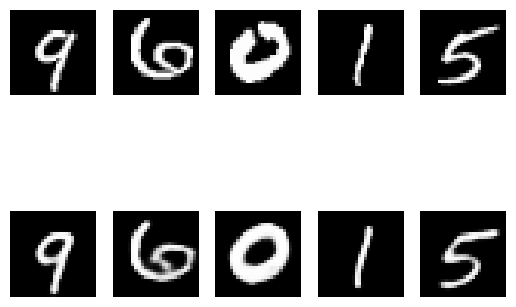

In [73]:
# reconstructing test images
test_imgs = next(iter(mnist_test_loader))[0]
display_ae1_images(vqvae_model, ae_maskgit, test_imgs, device)

It is reasonably good at the task (we could quantify this if we wanted).

### Encoding - full decoding capabilities

We will now test the __full encoding - decoding capabilities__ of the framework, by encoding images to a latent vector and reconstructing them purely from this latent vector. In other words, we start from __all masked image tokens__ and we do multi-step image generation conditioned on the latent vector.

In [74]:
def display_aef_images(vq_vae, ae_maskgit, test_imgs, device):
  '''
  Display a batch of input images along with their full reconstructions
  purely from the latent code
    First row: input images
    Second row: reconstructed images
  '''

  ae_maskgit.eval()

  n_images = 5
  idx = np.random.randint(0, test_imgs.shape[0], n_images)
  test_imgs = test_imgs[idx,:,:,:]

  # encode images to tokens
  img_tokens, _, _ = vq_vae.encode(test_imgs.to(device))

  # encode tokens to latent vector
  mu, _ = ae_maskgit.encode(img_tokens)

  # reconstruct tokens entirely from the latent vector mu
  # I suggest you set deterministic=True
  output_tokens = ae_maskgit.decode_test(mu, deterministic = True)

  # decode images from tokens
  # Don't forget to pass the output of vq_vae through a sigmoid to get images!
  output_imgs = vq_vae.decode(output_tokens)
  output_imgs = torch.sigmoid(output_imgs).detach().cpu().numpy()

  # print
  r = 2
  c = n_images
  fig, axs = plt.subplots(r, c)
  for j in range(c):
    axs[0,j].imshow(test_imgs[j, 0,:,:], cmap='gray')
    axs[0,j].axis('off')
    axs[1,j].imshow(output_imgs[j, 0,:,:], cmap='gray')
    axs[1,j].axis('off')
  plt.show()

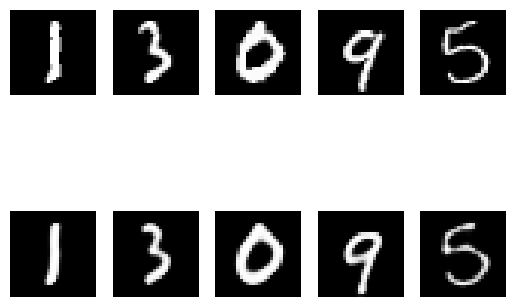

In [75]:
# reconstructing test images
ae_maskgit.steps = 20
test_imgs = next(iter(mnist_test_loader))[0]
display_aef_images(vqvae_model, ae_maskgit, test_imgs, device)
ae_maskgit.steps = decoding_steps

The model is decent at this. We can quantify this below. It does not reconstruct perfectly the digits (the autoencoding mechanism is a bit naive + it is a very small transformer), but compared to a vanilla VAE there is little blurring in the reconstructions. The reconstructions are semantically correct but there are a few perceptual mistakes.

### Compute quantitative reconstruction metrics

We will compute the binary cross entropy in image space.

In [76]:
ae_maskgit.eval()
vqvae_model.eval()
test_loss=0.0

ae_maskgit.steps = 8

with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    # Put the data on the correct device:
    x = data.to(device)

    # encode images to tokens
    img_tokens, _, _ = vqvae_model.encode(x)

    # encode tokens to latent vector
    mu, _ = ae_maskgit.encode(img_tokens)

    # decode latent vector to tokens
    output_tokens = ae_maskgit.decode_test(mu, mode="linear", temperature=1., deterministic=True)

    # decode images from tokens
    x_hat = vqvae_model.decode(output_tokens)

    # Compute the reconstruction loss
    # Hint: x_hat contains logits!
    loss = F.binary_cross_entropy_with_logits(x_hat, x, reduction="mean")

    # Compute the loss
    test_loss += loss.item()

    # tqdm bar displays the loss
    tepoch.set_postfix(loss=loss.item())

print('Test Loss: {:.4f}'.format(test_loss/len(mnist_test_loader)))

ae_maskgit.steps = decoding_steps

100%|██████████| 157/157 [00:06<00:00, 23.04batch/s, loss=0.118]

Test Loss: 0.1231


You can directly compare this number (0.1231 if you have the same model and code as I do) to the one we had obtained when simply autoencoding through the VQ-VAE part, which was 0.0713. The fact that the reconstructed digits are not blurry, but that there are a few perceptual reconstruction errors means that this binary cross-entropy metric is naturally a bit higher than it could be.

## 4.5. Generative capabilities of AE-MaskGIT

We have not yet tried to generate images from AE-MaskGIT (we've only done auto-encoding so far). To __generate images__, we should generate a latent vector from the prior $p(z)=N(z;0,1)$, then predict tokens from this latent vector (this part is done via `ae_maskgit.generate_samples()`) then decode the tokens back to image space (this part is done via `vqvae_model.decode()`).

In [77]:
def generate_images_aemaskgit(vq_vae, ae_maskgit, n_images=5):
    output_tokens = ae_maskgit.generate_samples(N=n_images, mode="cosine", temperature=10., randomize="warm_up", deterministic=True, r=None)
    x_hat = vqvae_model.decode(output_tokens)
    return torch.sigmoid(x_hat)

Now, generate some images. You can rerun the cell several times for more variety. (I am optionally increasing the number of decoding steps in AE-MaskGIT, to potentially improve the quality of samples)

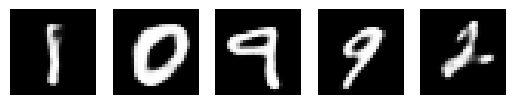

In [78]:
ae_maskgit.steps = 20

imgs_generated = generate_images_aemaskgit(vqvae_model, ae_maskgit)
display_images(imgs_generated)

ae_maskgit.steps = decoding_steps

__What do you think of these samples?__ Some are good, some are not so good. Let's try next to improve the quality of generated samples without fundamentally changing our model!

# 5. Generating better samples via Noise Contrastive Priors!

In the course, we have seen that a common issue of VAE-like models is the prior hole problem i.e., the __discrepancy between the prior and the aggregate posterior__ $p(z)$ and $q(z)$. We can try to fix that with the NCP-VAE strategy described in the course, which attempts to modify the prior after training the model $\tilde{p}(z)\propto p(z)r(z)$ to make it match the aggregate posterior $q(z)$ more closely.<br>

The closed-form solution of minimizing $KL(q(z)||\tilde{p}(z))$ w.r.t. $r$ yields $r(z):= q(z)/p(z)$, a quantity which can be estimated by the likelihood ratio trick. Specifically, we will train a discriminator network `D` (a small MLP) to discriminate samples from $q(z)$ (class 1) from samples from $p(z)=N(0,1)$ (class 0). After training the model, the logit `D(z)` output by the neural network is an estimate of $\log{q(z)/p(z)}$, so that $r(z)=\exp{D(z)}$.<br>

All that is left to do is to be able to sample from $\tilde{p}(z)\propto p(z)r(z)$. We will use sampling-importance-resampling, which proposes to
1.   sample from $p(z)$ `n_candidates` samples `z_i`
2.   compute `w_i=r(z_i)`
3.   sample an index `i` among the `n_candidates` with probability proportional to `w_i`

These three steps give us an approximate sample from $\tilde{p}(z)$.





We set out to implement this next!

## 5.1. Generating a dataset of samples from $q(z)$

The samples from $q(z)$ needed to train `D` are obtained by sampling randomly an image from MNIST trainset and computing the corresponding latent vector. Instead of doing it on the fly at each training iteration, which is fairly costly, we will precompute all the latent vectors in the `cMNIST` dataset, like we did previously with `tMNIST`.

In [79]:
class cMNIST(object):
    def __init__(self, ae_maskgit, tmnist_loader, device):
        ae_maskgit = ae_maskgit.to(device)
        self.data = self.process(ae_maskgit, tmnist_loader, device)

    def __getitem__(self, i):
        return self.data[i]

    def process(self, ae_maskgit, tmnist_loader, device):
        ae_maskgit.eval()
        latents = []

        with tqdm(tmnist_loader, unit="batch") as tepoch:
            for data in tepoch:
                # Put the data on the correct device:
                data = data.to(device)

                # Pass the data through the model
                mu, _ = ae_maskgit.encode(data)
                latents.append(mu.detach().clone().cpu().numpy())

        return np.concatenate(latents, axis=0)

    def __len__(self):
        return np.shape(self.data)[0]

In [80]:
cmnist_trainset = cMNIST(ae_maskgit, tmnist_train_loader, device)
cmnist_testset = cMNIST(ae_maskgit, tmnist_test_loader, device)

100%|██████████| 40/40 [00:00<00:00, 98.48batch/s]


In [81]:
batch_size = 256

cmnist_train_loader = torch.utils.data.DataLoader(cmnist_trainset, batch_size=batch_size, shuffle=True, drop_last=False)
cmnist_test_loader = torch.utils.data.DataLoader(cmnist_testset, batch_size=batch_size, shuffle=False, drop_last=False)

In [82]:
cmnist_trainset.data.shape

(60000, 10)

## 5.2. Building and training D

We will use as loss the `binary_cross_entropy_with_logits`, assigning the target for samples from $q$ as 1 and the target for samples from $p$ as 0.

In [83]:
def discriminator_loss(D, z_q, z_p):
    y_f = D(z_q)
    y_r = D(z_p)

    loss = 0.5 * (
            F.binary_cross_entropy_with_logits(y_f, torch.ones_like(y_f)) +
            F.binary_cross_entropy_with_logits(y_r, torch.zeros_like(y_r))
                )

    return loss

The `discriminator_model` maps from a latent code of dimension `latent_dim` to a single logit (-> probability to be a sample from $q(z)$).<br>

Build a model with:
1.   A linear layer that maps to a vector of size 128
2.   An ELU nonlinearity
3.   A LayerNorm
4.   A linear layer with 128 output neurons
5.   An ELU nonlinearity
6.   A LayerNorm
7.   A linear layer that produces the output



In [84]:
discriminator_model = nn.Sequential(
          nn.Linear(latent_dim, 128),
          nn.ELU(),
          nn.LayerNorm(128),
          nn.Linear(128, 128),
          nn.ELU(),
          nn.LayerNorm(128),
          nn.Linear(128, 1)
        )

In [85]:
discriminator_model = discriminator_model.to(device)

Let's train the model.

In [86]:
n_epoch_d = 10
learning_rate_d = 1e-3
optimizer_d = optim.AdamW(discriminator_model.parameters(), lr=learning_rate_d, weight_decay=1e-4)

In [87]:
discriminator_model.train()

for epoch in range(0,n_epoch_d):
  train_loss=0.0

  with tqdm(cmnist_train_loader, unit="batch") as tepoch:
    for data in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put data on correct device, GPU or CPU
      z_q = data.to(device)

      # Generate z_p from p(z)
      z_p = ae_maskgit.sample_pz(z_q.size(0))

      # Compute the discriminator loss
      loss = discriminator_loss(discriminator_model, z_q, z_p)

      # Backpropagate
      optimizer_d.zero_grad()
      loss.backward()
      optimizer_d.step()

      # Aggregate the training loss for display at the end of the epoch
      train_loss += loss.item()

      # tqdm bar displays the loss
      tepoch.set_postfix(losses=loss.item())

  print('Epoch {}: Discriminator Loss: {:.4f}'.format(epoch, train_loss/len(cmnist_train_loader)))

Epoch 0: 100%|██████████| 235/235 [00:01<00:00, 121.74batch/s, losses=0.598]


Epoch 0: Discriminator Loss: 0.6467


Epoch 1: 100%|██████████| 235/235 [00:01<00:00, 131.32batch/s, losses=0.625]


Epoch 1: Discriminator Loss: 0.5981


Epoch 2: 100%|██████████| 235/235 [00:01<00:00, 136.08batch/s, losses=0.572]


Epoch 2: Discriminator Loss: 0.5574


Epoch 3: 100%|██████████| 235/235 [00:01<00:00, 128.92batch/s, losses=0.489]


Epoch 3: Discriminator Loss: 0.5239


Epoch 4: 100%|██████████| 235/235 [00:01<00:00, 133.07batch/s, losses=0.488]


Epoch 4: Discriminator Loss: 0.4998


Epoch 5: 100%|██████████| 235/235 [00:01<00:00, 132.04batch/s, losses=0.465]


Epoch 5: Discriminator Loss: 0.4833


Epoch 6: 100%|██████████| 235/235 [00:02<00:00, 105.93batch/s, losses=0.481]


Epoch 6: Discriminator Loss: 0.4736


Epoch 7: 100%|██████████| 235/235 [00:01<00:00, 123.38batch/s, losses=0.475]


Epoch 7: Discriminator Loss: 0.4650


Epoch 8: 100%|██████████| 235/235 [00:01<00:00, 130.50batch/s, losses=0.488]


Epoch 8: Discriminator Loss: 0.4567


Epoch 9: 100%|██████████| 235/235 [00:01<00:00, 138.02batch/s, losses=0.44]

Epoch 9: Discriminator Loss: 0.4550


If it has trained properly, you can load a pretrained discriminator model instead if you want (that is only valid for the pretrained AE-MaskGIT model!)

In [88]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1kCFZXzW3uMaVjUIBTfa8yNJ79PgLj95Y' -O weights_discriminator.pth

will be placed in the single file you specified.

--2025-03-04 17:24:22--  https://drive.google.com/uc?export=download&id=1kCFZXzW3uMaVjUIBTfa8yNJ79PgLj95Y
Resolving drive.google.com (drive.google.com)... 142.250.107.113, 142.250.107.139, 142.250.107.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1kCFZXzW3uMaVjUIBTfa8yNJ79PgLj95Y&export=download [following]
--2025-03-04 17:24:23--  https://drive.usercontent.google.com/download?id=1kCFZXzW3uMaVjUIBTfa8yNJ79PgLj95Y&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.98.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78210 (76K) [application/octet-stream]
Saving to: ‘weights_discriminator.pth’

we

In [89]:
weights_dict = torch.load('weights_discriminator.pth')

<ipython-input-89-0083c9149c91>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_discriminator.pth')


In [90]:
discriminator_model.load_state_dict(weights_dict)

<All keys matched successfully>

In [91]:
discriminator_model = discriminator_model.to(device)

## 5.3. Using the noise contrastive prior

We build a small class that stores the trained discriminator and computes $r(z)$ given $z$ when it is called.

In [92]:
class r(object):
    def __init__(self, discriminator):
        self.D = discriminator
    def __call__(self, z):
        z = z.to(device)
        return torch.exp(self.D(z)).squeeze(-1)

In [93]:
r_model = r(discriminator_model)

All that is left is to complete the routine `sir` in the `AEMaskGIT` class if you have not done so yet. It implements the sampling importance resampling.<br>

After modifying the class `AEMaskGIT`, you may have to reinitialize the model for changes to be taken into account and to repopulate it with the pretrained weights. Then, you can run the cells below, which draw samples from the model using the NCP prior!

In [94]:
def generate_images_aemaskgit(vq_vae, ae_maskgit, n_images=5, r=None):
    output_tokens = ae_maskgit.generate_samples(N=n_images, mode="cosine", temperature=10., randomize="warm_up", deterministic=True, r=r)
    x_hat = vqvae_model.decode(output_tokens)
    return torch.sigmoid(x_hat)

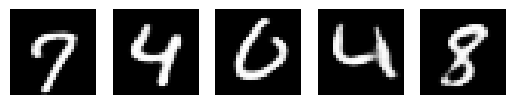

In [95]:
ae_maskgit.steps = 20

imgs_generated = generate_images_aemaskgit(vqvae_model, ae_maskgit, n_images=5, r=r_model)
display_images(imgs_generated)

ae_maskgit.steps = decoding_steps

The samples should now be qualitatively much better on average! In the final part of this lab, where you have nothing to code, we will quantify this.

# 6. Evaluating the quality of generated samples

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


The most widely accepted metric for evaluating the quality of generated images is the FID (Fréchet Inception Distance) which we have discussed in the course. You could implement it if you are interested, but we will opt for a simpler (and more naive) metric.

We will train a digit classifier on real MNIST samples. As the task is fairly easy, we will reach close to 100% accuracy. We will assume for this reason that a good digit is an image that can be easily classified into one of the 10 digits: in other words, an image for which the maximum of the 10 output probabilities is close to 1.<br>

We will hence __measure the generation quality__ as the average over generated images, of the maximum probability (computed separately for each generated image) $p_{i*}=\max_{i=1\dots 10} p_i$. The upper bound of the metric will be the test-time classification accuracy on real-digits, as fake digits will probably be harder to classify.

In [97]:
nb_classes = 10
nb_filters = 32
kernel_size = (3, 3)
pool_size = (2, 2)

mnist_classification_model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=kernel_size, stride=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(32),
        torch.nn.Conv2d(32, 64, kernel_size=kernel_size, stride=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(64),
        torch.nn.Conv2d(64, 128, kernel_size=kernel_size, stride=2, padding=1),
        torch.nn.ReLU(),
        torch.nn.BatchNorm2d(128),
        torch.nn.AvgPool2d(kernel_size=(4,4), stride=4),
        torch.nn.Flatten(),
        torch.nn.Linear(128, nb_classes)
    )

In [98]:
!wget --no-check-certificate -r 'https://drive.google.com/uc?export=download&id=1s9naPzcS_uOzX4Hhn9LxWEew7okv2Xg6' -O weights_classif.pth

will be placed in the single file you specified.

--2025-03-04 17:24:25--  https://drive.google.com/uc?export=download&id=1s9naPzcS_uOzX4Hhn9LxWEew7okv2Xg6
Resolving drive.google.com (drive.google.com)... 142.250.107.113, 142.250.107.139, 142.250.107.101, ...
Connecting to drive.google.com (drive.google.com)|142.250.107.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1s9naPzcS_uOzX4Hhn9LxWEew7okv2Xg6&export=download [following]
--2025-03-04 17:24:25--  https://drive.usercontent.google.com/download?id=1s9naPzcS_uOzX4Hhn9LxWEew7okv2Xg6&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.98.132, 2607:f8b0:400e:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 386982 (378K) [application/octet-stream]
Saving to: ‘weights_classif.pth’

weight

In [99]:
weights_dict = torch.load('weights_classif.pth')

<ipython-input-99-8f9053c268ef>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights_dict = torch.load('weights_classif.pth')


In [100]:
mnist_classification_model.load_state_dict(weights_dict)

<All keys matched successfully>

In [101]:
mnist_classification_model = mnist_classification_model.to(device)

Create a function to calculate accuracy, instead of loss

In [102]:
def vector_to_class(x):
  y = torch.argmax(F.softmax(x,dim=1),axis=1)
  return y

In [103]:
def cnn_accuracy(x_pred,x_label):
  acc = (x_pred == x_label).sum()/(x_pred.shape[0])
  return acc

In [104]:
mnist_classification_model.eval()

all_predicted = []
all_labels = []

with tqdm(mnist_test_loader, unit="batch") as tepoch:
  for imgs, labels in tepoch:
    all_labels.extend(labels.tolist())

    imgs = imgs.to(device)
    predict=mnist_classification_model(imgs)
    all_predicted.extend(vector_to_class(predict).tolist())

test_accuracy = cnn_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 157/157 [00:01<00:00, 105.04batch/s]


Test Accuracy: 0.983


0.983 will be our upper bound for the generative score. Let's code the __generative score__ as described above:

In [105]:
def generative_model_score(imgs_in,classification_model):
  gen_score = torch.mean(torch.max(F.softmax(classification_model(imgs_in),dim=1),axis=1)[0])
  return(gen_score)

Now, generate some images with and without the NCP prior, and evaluate these models (there still is some variability in the score even with 2000 images, don't hesitate to rerun the cell several times):

In [106]:
ae_maskgit.steps = 20
imgs_model_NCP = generate_images_aemaskgit(vqvae_model, ae_maskgit, n_images=2000, r=r_model)
imgs_model = generate_images_aemaskgit(vqvae_model, ae_maskgit, n_images=2000, r=None)
ae_maskgit.steps = decoding_steps

model_score_NCP = float(generative_model_score(imgs_model_NCP,mnist_classification_model))
model_score = float(generative_model_score(imgs_model,mnist_classification_model))

print('Upper bound: {}'.format(0.983))
print('Score without NCP: {}'.format(model_score))
print('Score with NCP: {}'.format(model_score_NCP))

Upper bound: 0.983
Score without NCP: 0.9274080991744995
Score with NCP: 0.9750217795372009


The score of the model with NCP is pretty good (around 0.975-0.98). The goal for this lab was not to train the best possible model (as decent results can be achieved with simpler models), but rather to learn a range of techniques while training a decent model.

__ps.__ Can you think of an __issue__ with the metric we used as a __generative score__, which would actually be more of an __issue for evaluating GAN models__?

The issue with the generative score metric is that it evaluates quality based on how well a classifier can recognize generated images instead of evaluating the similitude between the generated and training sets. It presents limitations, particularly when evaluating GANs or models generating more complex data. Indeed the generation of realistic images, which may not be easily classified. As a result, the score might unfairly penalize high-quality images that are hard for the classifier to label.

#References

Part of this notebook was adapted from Michael Alcorn's (airalcorn2's) VQ-VAE pytorch implementation under the following [Apache-2.0 license](https://github.com/airalcorn2/vqvae-pytorch/tree/master?tab=Apache-2.0-1-ov-file#readme). Another part was loosely adapted from valeo.ai's MaskGIT implementation under the following [MIT license](https://github.com/valeoai/Maskgit-pytorch/tree/main).